In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import torch

In [3]:
import bnn.data
import bnn.functions
import bnn.layer
import bnn.loss
import bnn.network
import bnn.optimizer

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Helper Funcs

In [5]:
def copy_weights(source: bnn.network.TernBinNetwork, target: bnn.network.TernBinNetwork):
    for name, layer in source.layers.items():
        target.layers[name].W.data = layer.W.data

In [6]:
def assert_same_weights(source: bnn.network.TernBinNetwork, target: bnn.network.TernBinNetwork):
    for name, layer in source.layers.items():
        assert torch.equal(target.layers[name].W.data, layer.W.data)

In [7]:
def grad_sign_confmats(
    input: torch.Tensor, 
    grad: torch.Tensor, 
    net1: bnn.network.TernBinNetwork, 
    net2: bnn.network.TernBinNetwork,
) -> dict[str, torch.Tensor]:
    # forward
    net1.forward(input)
    net2.forward(input)

    # backward
    net1.backward(grad)
    net2.backward(grad)

    confmats = {}
    for name in net1.layers:
        confmat = _grad_sign_confmat(net1.grad[name], net2.grad[name])
        confmats[name] = confmat
    
    return confmats


def _grad_sign_confmat(out1, out2):
    sign_out1 = torch.sign(out1)
    sign_out2 = torch.sign(out2)

    out = torch.empty(size=[3, 3])

    SYMBOLS = (-1, 0, 1)
    for i in SYMBOLS:
        for j in SYMBOLS:
            out[i, j] = torch.sum(sign_out2[sign_out1 == i] == j)

    out /= out.sum()
    return out


In [8]:
def print_confmat(confmat: torch.Tensor):
    print(
        "\t Actual grad sign\n"
        "\t 0 \t 1 \t -1 \t sum\n"
        "----------------------------------\n"
        f" 0  |\t {confmat[0, 0]:.3f} \t {confmat[1, 0]:.3f} \t {confmat[-1, 0]:.3f} \t| {confmat[:, 0].sum():.3f}\n"
        f" 1  |\t {confmat[0, 1]:.3f} \t {confmat[1, 1]:.3f} \t {confmat[-1, 1]:.3f} \t| {confmat[:, 1].sum():.3f}\n"
        f"-1  |\t {confmat[0, -1]:.3f} \t {confmat[1, -1]:.3f} \t {confmat[-1, -1]:.3f} \t| {confmat[:, -1].sum():.3f}\n"
        "----------------------------------\n"
        f"sum |\t {confmat[0, :].sum():.3f} \t {confmat[1, :].sum():.3f} \t {confmat[-1, :].sum():.3f} \t| {confmat.sum():.3f}\n"
    )

In [9]:
def confmat_nonzero_sign_error(confmat) -> float:
    nonzero = confmat[1].sum() + confmat[-1].sum()
    wrong_sign = confmat[1, -1] + confmat[-1, 1]

    prop = wrong_sign / nonzero

    return prop.item()

def confmat_nonzero_sign_error_inc0(confmat) -> float:
    nonzero = confmat[1].sum() + confmat[-1].sum()
    wrong_sign = confmat[1, -1] + confmat[-1, 1]
    zero = confmat[1, 0] + confmat[-1, 0]

    prop = (wrong_sign + zero) / nonzero

    return prop.item()

def confmat_tern_grad_wrong_sign(confmat) -> float:
    nonzero = confmat[:, 1].sum() + confmat[:, -1].sum()
    wrong_sign = confmat[1, -1] + confmat[-1, 1]

    prop = wrong_sign / nonzero

    return prop.item()

def confmat_tern_grad_wrong_sign_inc_0(confmat) -> float:
    nonzero = confmat[:, 1].sum() + confmat[:, -1].sum()
    wrong_sign = confmat[1, -1] + confmat[0, -1] + confmat[-1, 1] + confmat[0, 1]

    prop = wrong_sign / nonzero

    return prop.item()

def confmat_lost_grads(confmat) -> float:
    zero_grad = confmat[:, 0].sum()
    wrong_zero_grad = confmat[1, 0] + confmat[-1, 0]

    prop = wrong_zero_grad / zero_grad

    return prop.item()

### Setup

In [10]:
forward_func = bnn.functions.forward.SignBinarise()
#forward_func=bnn.functions.forward.LayerMeanBinarise()
#forward_func=bnn.functions.forward.LayerMedianBinarise()

In [11]:
backward_funcs = {
    'sign': bnn.functions.backward.SignTernarise(),
    'stochastic': bnn.functions.backward.StochasticTernarise(alpha=0.5),
    'layer_mean': bnn.functions.backward.LayerMeanStdTernarise(half_range_stds=0.5),
    'layer_quantile': bnn.functions.backward.LayerQuantileTernarise(lo=0.33, hi=0.67),
    'layer_quantile_symmetric': bnn.functions.backward.LayerQuantileSymmetricTernarise(prop_zero=0.33),
}

In [12]:
INPUT_DIM = 128
OUTPUT_DIM = 8

In [13]:
HIDDEN_DIM = INPUT_DIM
NUM_LAYERS = 8

In [14]:
dims = [INPUT_DIM] + [HIDDEN_DIM] * (NUM_LAYERS - 1) + [OUTPUT_DIM]

In [15]:
proj_TBNNs = {}
for plot_name, backward_func in backward_funcs.items():
    proj_TBNN = bnn.network.TernBinNetwork(
        dims,
        forward_func=forward_func,
        backward_func=backward_func,
    )
    proj_TBNNs[plot_name] = proj_TBNN

In [16]:
noproj_TBNN = bnn.network.TernBinNetwork(
    dims,
    forward_func=forward_func,
    backward_func=bnn.functions.backward.ActualGradient(),
)

### Initialise

In [17]:
stable_zero_prob = 0.99 * (1 - 1/HIDDEN_DIM)
noproj_TBNN._initialise(W_mean=0, W_zero_prob=stable_zero_prob)
list(noproj_TBNN.layers.values())[-1]._initialise_W(mean=0, zero_prob=0.33)

In [18]:
for proj_TBNN in proj_TBNNs.values():
    copy_weights(source=noproj_TBNN, target=proj_TBNN)
    assert_same_weights(source=proj_TBNN, target=noproj_TBNN)

### Check gradients

In [19]:
list(noproj_TBNN.layers.values())[0].W.dtype

torch.int64

In [20]:
import collections
import tqdm

In [21]:
all_confmats = collections.defaultdict(list)

NUM_EXPS = 100
NUM_SAMPLES = 1024

for i in tqdm.tqdm(range(NUM_EXPS)):
    stable_zero_prob = 0.99 * (1 - 1/HIDDEN_DIM)
    noproj_TBNN._initialise(W_mean=0, W_zero_prob=stable_zero_prob)
    list(noproj_TBNN.layers.values())[-1]._initialise_W(mean=0, zero_prob=0.33)

    input = bnn.random.generate_random_binary_tensor(shape=[NUM_SAMPLES, INPUT_DIM], mean=0)
    grad = bnn.random.generate_random_binary_tensor(shape=[NUM_SAMPLES, OUTPUT_DIM], mean=0)

    for plot_name, proj_TBNN in proj_TBNNs.items():
        copy_weights(source=noproj_TBNN, target=proj_TBNN)
        assert_same_weights(source=proj_TBNN, target=noproj_TBNN)

        confmats = grad_sign_confmats(input=input, grad=grad, net1=noproj_TBNN, net2=proj_TBNN)
        all_confmats[plot_name].append(confmats)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [07:01<00:00,  4.21s/it]


In [22]:
len(all_confmats)

5

In [23]:
def average_metrics(metrics_list: list[dict]) -> dict:
    top_average = collections.defaultdict(
            lambda: collections.defaultdict(int)
    )

    for metrics in metrics_list:
        for layer_name, layer_metrics in metrics.items():
            for bot_key, metric in layer_metrics.items():
                top_average[layer_name][bot_key] += metric / len(metrics_list)

    return top_average

In [24]:
metricsss = {}

for net_name, confmats_list in all_confmats.items():
        metricss_list = []

        for confmats in confmats_list:
            metricss = {}

            for plot_name, confmat in confmats.items():
                metrics = {}

                tern_grad_wrong_sign = confmat_tern_grad_wrong_sign(confmat)
                metrics['tern_grad_wrong_sign'] = tern_grad_wrong_sign

                lost_grads = confmat_lost_grads(confmat)
                metrics['lost_grads'] = lost_grads

                metricss[plot_name] = metrics

            metricss_list.append(metricss)

        metricsss[net_name] = average_metrics(metricss_list)

In [25]:
import collections

plotss = {}

for func_name, metricss in metricsss.items():
    plots = collections.defaultdict(list)

    for metrics in metricss.values():
        for plot_name, metric in metrics.items():
            plots[plot_name].append(metric)

    plotss[func_name] = plots

In [27]:
import matplotlib.pyplot as plt

In [28]:
plt.rcParams.update({'font.size': 12})

'lost_grads'
'lost_grads'
'lost_grads'
'lost_grads'
'lost_grads'


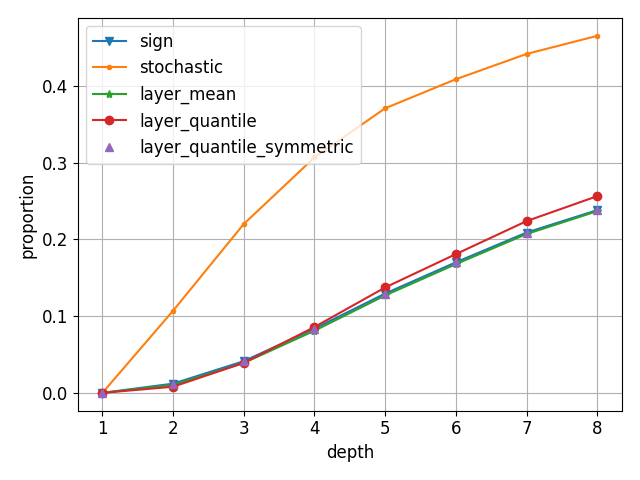

In [29]:
import matplotlib.pyplot as plt

FIG_NAME = "metrics by layer"
plt.close(FIG_NAME)

fig, axs = plt.subplots(1, 1, num=FIG_NAME)

if isinstance(axs, list):
    axes = {
        'lost_grads': axs[0],
        'tern_grad_wrong_sign': axs[1]
    }
else:
    axes = {'lost_grads': axs}
    axes = {'tern_grad_wrong_sign': axs}

styles = ['v-', '.-', '*-', 'o-', '^']
for i, (layer_name, plots) in enumerate(plotss.items()):
    for j, (plot_name, plot) in enumerate(plots.items()):
        try:
            style = styles[i % len(styles)]
            axes[plot_name].plot(list(range(1, len(plot)+1)), list(reversed(plot)), style, label=layer_name)
        except KeyError as e:
            print(e)

for plot_name, ax in axes.items():
    #ax.set_title(plot_name)
    ax.grid()
    ax.legend()
    ax.set_xlabel('depth')
    ax.set_ylabel('proportion')

fig.tight_layout()

SAVE_DIR = "figures/"
plt.savefig(f"{SAVE_DIR}{plot_name}.pdf", format="pdf", bbox_inches="tight")
plt.show()



In [ ]:
# Metrics
## Not sooo bad if there is an incorrect zero gradient...
## What is bad is a gradient being the wrong sign

## What proportion of the nonzero binarised gradients are the wrong sign?

In [ ]:
# Plot
## x-axis layer
## y-axis prop. incorrect gradient
## different lines for different ternarisation methods

In [ ]:
import matplotlib.pyplot as plt

import bnn.metrics

In [ ]:
noproj_grad_ds: list[bnn.random.DISCRETE_DIST | None] = []
for grad in noproj_TBNN.grad.values():
    d = bnn.metrics.distribution(grad.cpu())
    noproj_grad_ds.append(d)
    
proj_grad_ds: list[bnn.random.DISCRETE_DIST | None] = []
for grad in proj_TBNN.grad.values():
    d = bnn.metrics.distribution(grad.cpu())
    proj_grad_ds.append(d)

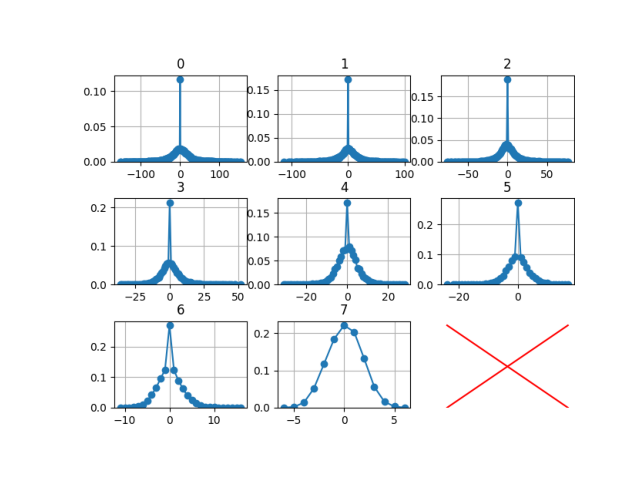

In [ ]:
image = bnn.metrics.distribution_plot(noproj_grad_ds)

FIG_NAME = "noproj_grad_dist"

plt.close(FIG_NAME)
plt.figure(FIG_NAME)
plt.imshow(image)
plt.axis('off')
plt.show()

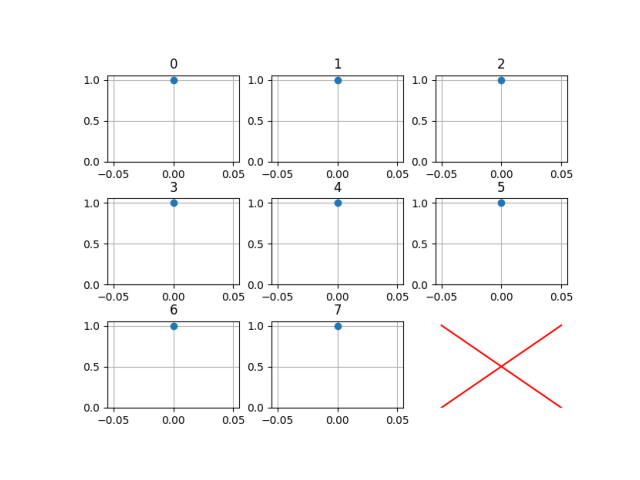

In [ ]:
image = bnn.metrics.distribution_plot(proj_grad_ds)

FIG_NAME = "grad_dist"

plt.close(FIG_NAME)
plt.figure(FIG_NAME)
plt.imshow(image)
plt.axis('off')
plt.show()